In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hdbscan
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture 
from scipy.stats import wasserstein_distance
from sklearn.metrics import mutual_info_score
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
import math
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
np.random.seed(42)

In [4]:
def variation_of_information(labels_true, labels_pred):
   labels_true = np.asarray(labels_true, dtype=np.int32)
   labels_pred = np.asarray(labels_pred, dtype=np.int32)
   contingency = np.histogram2d(labels_true, labels_pred, bins=(np.max(labels_true) + 1, np.max(labels_pred) + 1))[0]
   H_true = -np.sum(contingency.sum(axis=1) / len(labels_true) * np.log(contingency.sum(axis=1) / len(labels_true)))
   H_pred = -np.sum(contingency.sum(axis=0) / len(labels_pred) * np.log(contingency.sum(axis=0) / len(labels_pred)))
   I = mutual_info_score(labels_true, labels_pred)
   return H_true + H_pred - 2 * I

In [5]:
def optimize_clustering(params, data, true_labels, algorithm, manual_n_clusters=None):
   random_state = 42
   if algorithm == 'HDBSCAN':
       clusterer = hdbscan.HDBSCAN(min_samples=int(params['min_samples']),
                                   min_cluster_size=int(params['min_cluster_size']),
                                   metric=params['metric'],
                                   cluster_selection_method=params['cluster_selection_method'])
   elif algorithm == 'KMeans':
       clusterer = KMeans(n_clusters=manual_n_clusters if manual_n_clusters else int(params['n_clusters']), random_state=42, n_init=10)
   elif algorithm == 'AgglomerativeClustering':
       linkage = params['linkage'] 
       affinity = 'euclidean' if linkage == 'ward' else params['affinity'] 
       clusterer = AgglomerativeClustering(n_clusters=manual_n_clusters if manual_n_clusters else int(params['n_clusters']), affinity=affinity, linkage=linkage)
  
   cluster_labels = clusterer.fit_predict(data)
   if len(np.unique(cluster_labels)) > 1:
       silhouette_avg = silhouette_score(data, cluster_labels)
       ari = adjusted_rand_score(true_labels, cluster_labels)
       score = 0.5 * silhouette_avg + 0.5 * ari  
   else:
       score = -1
   return {'loss': -score, 'status': STATUS_OK}

In [7]:
def bayesian_optimization(data, true_labels, algorithm, manual_n_clusters=None):
   if algorithm == 'HDBSCAN':
       space = {
           'min_samples': hp.quniform('min_samples', 5, 100, 1),
           'min_cluster_size': hp.quniform('min_cluster_size', 2, 100, 1),
           'metric': hp.choice('metric', ['euclidean', 'manhattan']),
           'cluster_selection_method': hp.choice('cluster_selection_method', ['eom', 'leaf'])
       }
   elif algorithm == 'KMeans':
       space = {
           'n_clusters': hp.quniform('n_clusters', 2, 20, 1)
       }
   elif algorithm == 'AgglomerativeClustering':
       space = {
           'n_clusters': hp.quniform('n_clusters', 2, 20, 1),
           'affinity': hp.choice('affinity', ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']),
           'linkage': hp.choice('linkage', ['ward', 'complete', 'average', 'single'])
       }
   trials = Trials()

   rng = np.random.default_rng(42)
   best = fmin(fn=lambda params: optimize_clustering(params, data, true_labels, algorithm, manual_n_clusters),
               space=space,
               algo=tpe.suggest,
               max_evals=200,
               trials=trials,
               rstate=rng)
   if algorithm == 'HDBSCAN':
       best_params = {
           'min_samples': int(best['min_samples']),
           'min_cluster_size': int(best['min_cluster_size']),
           'metric': ['euclidean', 'manhattan'][best['metric']],
           'cluster_selection_method': ['eom', 'leaf'][best['cluster_selection_method']]
       }
   elif algorithm == 'KMeans':
       best_params = {
           'n_clusters': manual_n_clusters if manual_n_clusters else int(best['n_clusters'])
       }
   elif algorithm == 'AgglomerativeClustering':
      best_params = { 'n_clusters': manual_n_clusters if manual_n_clusters else int(best['n_clusters']), 
                      'affinity': 'euclidean' if best['linkage'] == 0 else ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'][best['affinity']], 
                      'linkage': ['ward', 'complete', 'average', 'single'][best['linkage']] 
       }
   return best_params


In [8]:
def clustering_pipeline(feat_df, y_param, colors, s, algorithm, manual_n_clusters=None, subset_values=None ):
   ideal_perplexity = math.sqrt(feat_df.shape[0])
   standardized_data = StandardScaler().fit_transform(feat_df)
   tsne = TSNE(n_components=2, perplexity=ideal_perplexity, n_jobs=-1, n_iter=1000,
               learning_rate='auto', init='random', random_state=42)
   tsne_results = tsne.fit_transform(standardized_data)
   tsne_df = pd.DataFrame(data=tsne_results, columns=['t-SNE 1', 't-SNE 2'])
    
   if subset_values is not None:
       subset_indices = y_param.isin(subset_values)
       tsne_df = tsne_df[subset_indices].reset_index(drop=True)
       y_param = y_param[subset_indices].reset_index(drop=True)
           
   best_params = bayesian_optimization(tsne_df, y_param, algorithm, manual_n_clusters)
   print(f"Best {algorithm} parameters:", best_params)
    
   if algorithm == 'HDBSCAN':
       clusterer = hdbscan.HDBSCAN(min_samples=best_params['min_samples'],
                                   min_cluster_size=9,
                                   metric=best_params['metric'],
                                   cluster_selection_method=best_params['cluster_selection_method'])
   elif algorithm == 'KMeans':
       clusterer = KMeans(n_clusters=best_params['n_clusters'], random_state=42, n_init=10)
   elif algorithm == 'AgglomerativeClustering':
       clusterer = AgglomerativeClustering(n_clusters=best_params['n_clusters'], affinity=best_params['affinity'], linkage=best_params['linkage'])
   cluster_labels = clusterer.fit_predict(tsne_df)
   tsne_df['Cluster'] = cluster_labels
           
  
   le = LabelEncoder()
   encoded_y_param = le.fit_transform(y_param)
   vi = variation_of_information(encoded_y_param, cluster_labels)
   ari = adjusted_rand_score(encoded_y_param, cluster_labels)
   wd = wasserstein_distance(encoded_y_param, cluster_labels)
   sil = silhouette_score(tsne_df[['t-SNE 1', 't-SNE 2']] , cluster_labels)
   print(f"Variation of Information: {vi}")
   print(f"Adjusted Rand Index: {ari}")
   print(f"Wasserstein Distance: {wd}")
   print(f"Silhoutte Score: {sil}")
 
  
   contingency_table = pd.crosstab(pd.Series(y_param, name='Ground Truth'), pd.Series(cluster_labels, name='Cluster'))
   contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
   contingency_table_inverse_percentage = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100
   print("\nContingency Table (Ground Truth vs Cluster):")
   print(contingency_table)
   print("\nPercentage of each Ground Truth in each Cluster:")
   print(contingency_table_percentage)
   print("\nPercentage of each Cluster in each Ground Truth:")
   print(contingency_table_inverse_percentage)
  
   fig = plt.figure(figsize=(12, 12))
   ax = fig.add_subplot(1, 1, 1)
   ax.set_title(f't-SNE and {algorithm} clustering', fontsize=20)
   ax.grid(False)
   unique_clusters = np.unique(cluster_labels)
   for cluster in unique_clusters:
       indicesToKeep = tsne_df['Cluster'] == cluster
       ax.scatter(tsne_df.loc[indicesToKeep, 't-SNE 1'],
                  tsne_df.loc[indicesToKeep, 't-SNE 2'],
                  c=colors[cluster % len(colors)],
                  s=s, label=f'Cluster {cluster}')
   ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
   #plt.savefig(f't-SNE and {algorithm} clustering.png')
   plt.show()

In [11]:
colors = [
    '#00c853', # Green
    '#d50000', # Red
]
all_colors = [
    '#d50000', # Red
    '#3e2723', # Brown
    '#00c853', # Green
    '#2962ff', # Blue
    '#ff6d00', # Orange
    '#6200ea', # Deep Purple
    '#c51162', # Pink
    '#0091ea', # Light Blue
    '#aeea00', # Lime
    '#2196f3', # Blue 2
    '#304ffe', # Indigo
    '#aa00ff', # Purple
    '#263238', # Blue Grey
    '#00b8d4', # Cyan
    '#ffab00', # Amber
    '#9e9e9e', # Grey 2
    '#ffc107', # Golden
    '#00bcd4', # Cyan 2
    '#00bfa5', # Teal
    '#ff6d00', # Orange
    '#dd2c00', # Deep Orange
    '#212121', # Grey
    '#9c27b0', # Purple 2
    '#ff5722', # Orange 2
    '#4caf50', # Green 2
    '#c51162', # Pink
    '#00bfa5', # Teal
    '#64dd17', # Light Green
    '#f44336', # Red 2
    '#795548', # Brown 2
    '#607d8b', # Blue Grey 2
    '#e91e63', # Pink 2

]

nine_colors = [
    '#d50000', # Red
    '#00c853', # Green
    '#ff6d00', # Orange
    '#2962ff', # Blue
    '#3e2723', # Brown
    '#00bfa5', # Teal
    '#6200ea', # Deep Purple
    '#c51162', # Pink
    '#aeea00', # Lime

]


## Importing Datasets

In [12]:
# import clinical df 
clinical_df = pd.read_excel(r"C:\Users\m.soliman\Downloads\Clinical\PANCANCER_clin_v3.xlsx")
#clinical_df

In [13]:
feature_df = pd.read_csv(r"C:\Users\m.soliman\Downloads\Radiomics\20230921_PANCANCER_radiomics.csv")
#feature_df

In [14]:
feature_df =feature_df.drop(feature_df.columns[[0, 1, 9, 10, 11, 12, 13, 14,15, -1]], axis =1)
#feature_df

In [15]:
feature_df = pd.merge(feature_df, clinical_df[['Scan_Name', 'tumtype']], on="Scan_Name", how='left')

## Pre-Processing

In [16]:
def classify_segment(segment):
   if segment==0:
       return 'Primary'
   elif segment==1:
       return 'Lymph Nodes'
   elif segment==2:
       return 'Lung mets'
   elif segment==3:
       return 'Liver mets'
   elif segment==4:
       return 'Abdopelvis mets'
   elif segment==5:
       return 'Bone mets'
   elif segment==6:
       return 'Brain mets'
   elif segment==7:
       return 'Adrenal mets'
   else:
       return 'Others'

In [17]:
feature_df['lesion_type'] = feature_df['Segment Name'].astype(str).str[0].astype(int)
categories = ['CRC', 'Sarcoma', 'melanoma', 'ovary', 'lung']
feature_df['categories']= feature_df['tumtype'].apply(lambda x: x if x in categories else 'none')
one_hot_encoded_df = pd.get_dummies(feature_df['categories'], prefix='tumtype').astype(int)
names = {
    'tumtype_CRC':'binary CRC',
    'tumtype_Sarcoma':'binary Sarcoma',
    'tumtype_melanoma':'binary Melanoma',
    'tumtype_ovary':'binary Ovary',
    'tumtype_lung':'binary lung',}
one_hot_encoded_df.rename(columns=names, inplace=True)
one_hot_encoded_df = one_hot_encoded_df.drop('tumtype_none', axis=1)
feature_df = pd.concat([feature_df, one_hot_encoded_df], axis=1)
feature_df = feature_df.rename(columns={'tumtype': 'tumour_type3_y'})
feature_df = feature_df.drop('categories', axis=1)
feature_df['binary primary metastasis'] = (~feature_df['Segment Name'].astype(str).apply(lambda x: x.startswith('0'))).astype(int)
feature_df['Location'] = feature_df['lesion_type'].apply(classify_segment)

In [18]:
feature_df

,Scan_Name,Segment ID,Segment Name,Segment index,Label,Label_channel,Dimensionality,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,...,lbp-3D-k_ngtdm_Contrast,lbp-3D-k_ngtdm_Strength,tumour_type3_y,lesion_type,binary CRC,binary Sarcoma,binary lung,binary Ovary,binary primary metastasis,Location
0,PANCANCER_0003,Segment_1,0.1,0,1,0,3D,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {'binWidth': 5.0}, 'Square': {'bi...",7aa630b85deda100e6b454ed984f95effa8ed1ba,...,0.017062,0.047564,lung,0,0,0,1,0,0,Primary
1,PANCANCER_0003,Segment_2,1.1,1,2,0,3D,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {'binWidth': 5.0}, 'Square': {'bi...",7aa630b85deda100e6b454ed984f95effa8ed1ba,...,0.042557,0.048207,lung,1,0,0,1,0,1,Lymph Nodes
2,PANCANCER_0003,Segment_3,1.2,2,3,0,3D,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {'binWidth': 5.0}, 'Square': {'bi...",7aa630b85deda100e6b454ed984f95effa8ed1ba,...,0.014769,0.065413,lung,1,0,0,1,0,1,Lymph Nodes
3,PANCANCER_0003,Segment_4,2.1,3,4,0,3D,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {'binWidth': 5.0}, 'Square': {'bi...",7aa630b85deda100e6b454ed984f95effa8ed1ba,...,0.031263,0.184482,lung,2,0,0,1,0,1,Lung mets
4,PANCANCER_0003,Segment_5,2.2,4,5,0,3D,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {'binWidth': 5.0}, 'Square': {'bi...",7aa630b85deda100e6b454ed984f95effa8ed1ba,...,0.051468,0.164960,lung,2,0,0,1,0,1,Lung mets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11163,PANCANCER_1813,Segment_3,3.3,2,3,0,3D,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {'binWidth': 5.0}, 'Square': {'bi...",06ec93b113a873cac6167dd38c09fcf44a8bd8c4,...,0.016953,0.143187,CRC,3,1,0,0,0,1,Liver mets
11164,PANCANCER_1814,Segment_1,0.1,0,1,0,3D,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {'binWidth': 5.0}, 'Square': {'bi...",b3048f3e6dcb472b05ae1694c0045e521c3b0b65,...,0.038713,0.033966,lung,0,0,0,1,0,0,Primary
11165,PANCANCER_1814,Segment_2,3.1,1,2,0,3D,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {'binWidth': 5.0}, 'Square': {'bi...",b3048f3e6dcb472b05ae1694c0045e521c3b0b65,...,0.012895,0.029939,lung,3,0,0,1,0,1,Liver mets
11166,PANCANCER_1815,Segment_1,0.1,0,1,0,3D,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {'binWidth': 5.0}, 'Square': {'bi...",6b828b44b16ba0a9e1fb95f132c542dbb2c1984b,...,0.004246,0.001257,Sarcoma,0,0,1,0,0,0,Primary


## Defining tumor df and y param

In [19]:
x_start = feature_df.columns.get_loc('original_shape_Elongation')
x_end = feature_df.columns.get_loc('lbp-3D-k_ngtdm_Strength')+1

In [20]:
# definition of all tumors df 
all_df = feature_df.dropna(subset='tumour_type3_y')
all_df = all_df.iloc[:, x_start:x_end].fillna(all_df.median(numeric_only=True))


In [21]:
# definition of primary df and y_param 
primary_df = feature_df[feature_df['lesion_type'] == 0]
primary_df = primary_df.dropna(subset='tumour_type3_y')
primary_feat_df = primary_df.iloc[:, x_start:x_end].fillna(feature_df.median(numeric_only=True))

primary_lung_y_param = primary_df['binary lung'].reset_index(drop=True)

In [22]:
## Step 1: all tumor types with patient level(diagnosis) label and anatomical location

patient_level_y_param = feature_df['tumour_type3_y']
Location_y_param = feature_df['Location']

# Clustering

## Clustering of all lesions

100%|██████████| 200/200 [03:14<00:00,  1.03trial/s, best loss: -0.3607935358989379]
Best KMeans parameters: {'n_clusters': 6}
Variation of Information: 1.9328583295704624
Adjusted Rand Index: 0.3607935358989379
Wasserstein Distance: 2.1285475792988313
Silhoutte Score: 0.4690852463245392

Contingency Table (Ground Truth vs Cluster):
Cluster             0     1     2    3     4    5
Ground Truth                                     
Abdopelvis mets    48    66   545  300     5    9
Adrenal mets        2    21    72   46     0    0
Bone mets          36     9    30    7     3  946
Brain mets          1    19     0   17     0    0
Liver mets        128  1159   170  935     6    3
Lung mets         542     4    30   21  1932    5
Lymph Nodes      1024   211  1056  423     7   15
Primary           484    19    64  294    56   12

Percentage of each Ground Truth in each Cluster:
Cluster                  0          1          2          3          4  \
Ground Truth                             

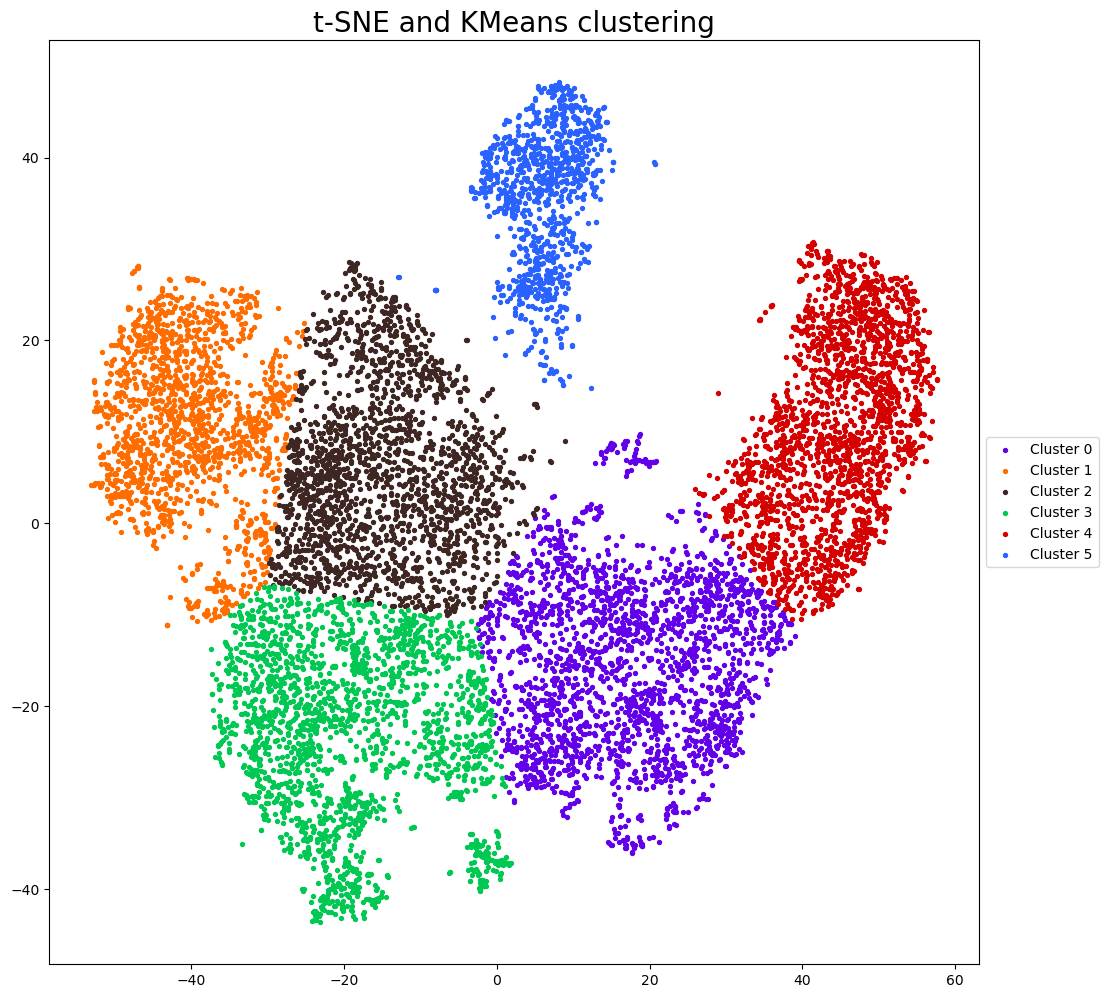

In [69]:
clustering_pipeline(feat_df=all_df, y_param=Location_y_param, colors=all_colors, s=8, algorithm='KMeans', subset_values=['Primary', 'Lymph Nodes', 'Lung mets', 'Liver mets', 'Bone mets', 'Adrenal mets', 'Abdopelvis mets', 'Brain mets'])                           

100%|██████████| 200/200 [10:36<00:00,  3.18s/trial, best loss: -0.3922300485071426]
Best AgglomerativeClustering parameters: {'n_clusters': 6, 'affinity': 'euclidean', 'linkage': 'ward'}
Variation of Information: 1.929028652444075
Adjusted Rand Index: 0.3922300485071426
Wasserstein Distance: 2.145798553144129
Silhoutte Score: 0.4259781539440155

Contingency Table (Ground Truth vs Cluster):
Cluster             0     1     2    3    4     5
Ground Truth                                     
Abdopelvis mets     6   574   221   10   39   123
Adrenal mets        0    59    71    0    8     3
Bone mets           5    33    11  941    5    36
Brain mets          0     0     3    0   16    18
Liver mets          7   227  1017    3  951   196
Lung mets        2185    33    20    5    1   290
Lymph Nodes        60  1144   301   18  111  1102
Primary           164   101   223   12   10   419

Percentage of each Ground Truth in each Cluster:
Cluster                  0          1          2        

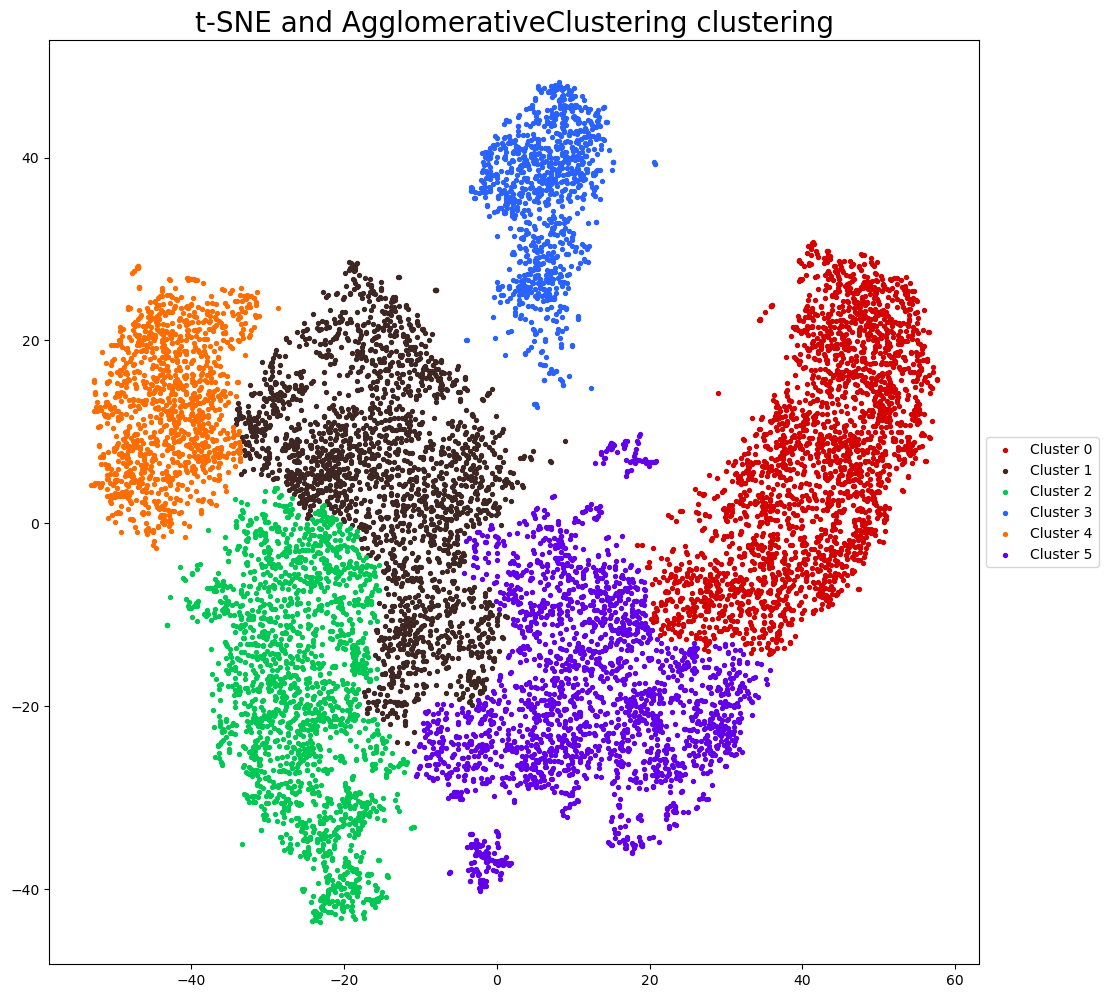

In [71]:
clustering_pipeline(feat_df=all_df, y_param=Location_y_param, colors=all_colors, s=8, algorithm='AgglomerativeClustering', manual_n_clusters=None, subset_values=['Primary', 'Lymph Nodes', 'Lung mets', 'Liver mets', 'Bone mets', 'Adrenal mets', 'Abdopelvis mets', 'Brain mets'])                    

## All lesions except primary

100%|██████████| 200/200 [03:08<00:00,  1.06trial/s, best loss: -0.41682685355365445]
Best KMeans parameters: {'n_clusters': 6}
Variation of Information: 1.7261291421958673
Adjusted Rand Index: 0.41682685355365445
Wasserstein Distance: 1.945295848980006
Silhoutte Score: 0.48130378127098083

Contingency Table (Ground Truth vs Cluster):
Cluster             0     1    2     3    4     5
Ground Truth                                     
Abdopelvis mets     5   513  284   100    9    62
Adrenal mets        0    72   47     2    0    20
Bone mets           3    31   10    37  944     6
Brain mets          0     0   17     4    0    16
Liver mets          7   156  943   206    3  1086
Lung mets        2046    29   22   429    5     3
Lymph Nodes        11  1000  345  1164   15   201

Percentage of each Ground Truth in each Cluster:
Cluster                  0          1          2          3          4  \
Ground Truth                                                             
Abdopelvis mets

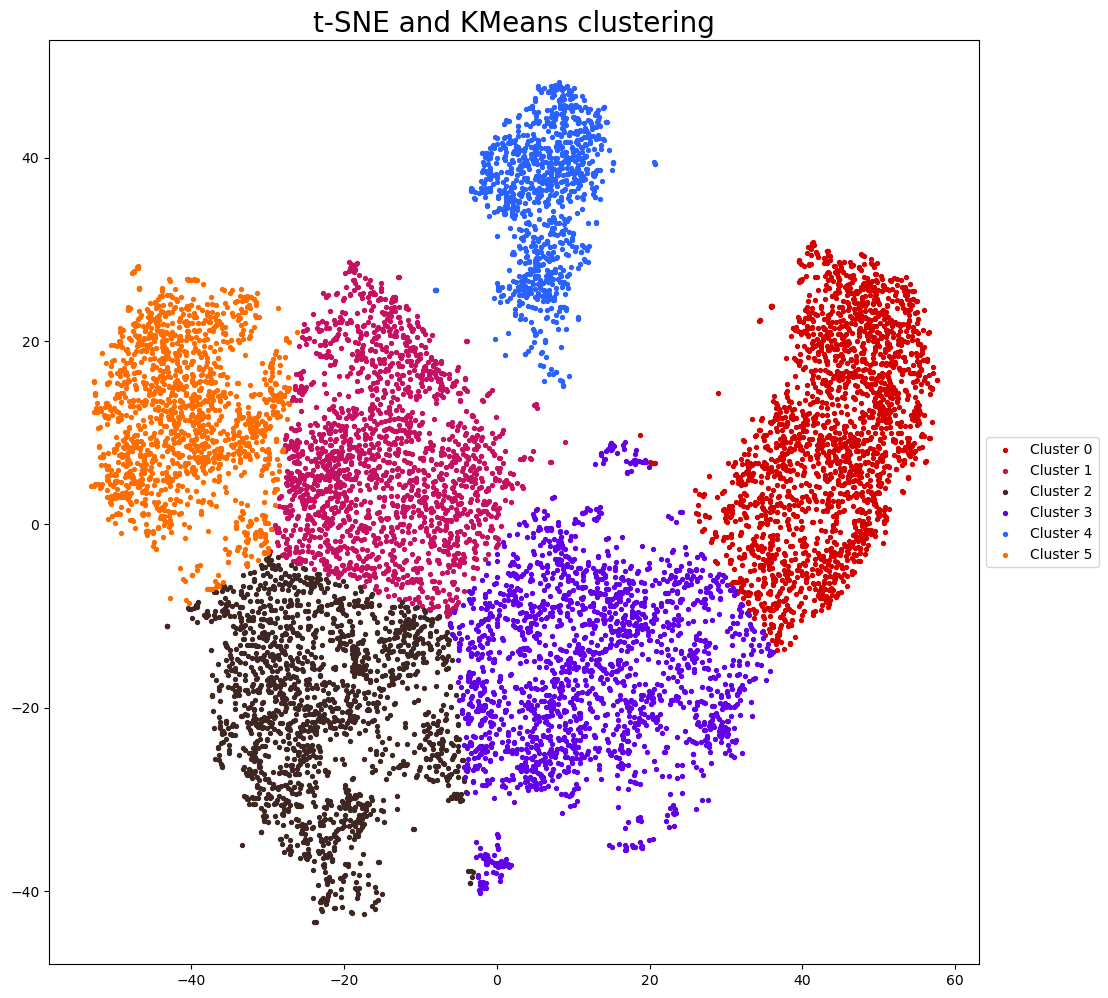

In [37]:
clustering_pipeline(feat_df=all_df, y_param=Location_y_param, colors=all_colors, s=8, algorithm='KMeans', manual_n_clusters=None, subset_values=['Lymph Nodes', 'Lung mets', 'Liver mets', 'Bone mets', 'Adrenal mets', 'Abdopelvis mets', 'Brain mets'])                    

100%|██████████| 200/200 [06:04<00:00,  1.82s/trial, best loss: -0.41828961706326856]
Best AgglomerativeClustering parameters: {'n_clusters': 6, 'affinity': 'euclidean', 'linkage': 'ward'}
Variation of Information: 1.7282241150565008
Adjusted Rand Index: 0.41828961706326856
Wasserstein Distance: 2.022531208768903
Silhoutte Score: 0.47190770506858826

Contingency Table (Ground Truth vs Cluster):
Cluster             0     1     2    3    4    5
Ground Truth                                    
Abdopelvis mets     5   308   131   10  476   43
Adrenal mets        0    77     4    0   48   12
Bone mets           5    18    36  937   30    5
Brain mets          0     3    18    0    0   16
Liver mets          7  1042   242    2  122  986
Lung mets        2118    27   360    5   23    1
Lymph Nodes        18   510  1211   18  835  144

Percentage of each Ground Truth in each Cluster:
Cluster                  0          1          2          3          4  \
Ground Truth                         

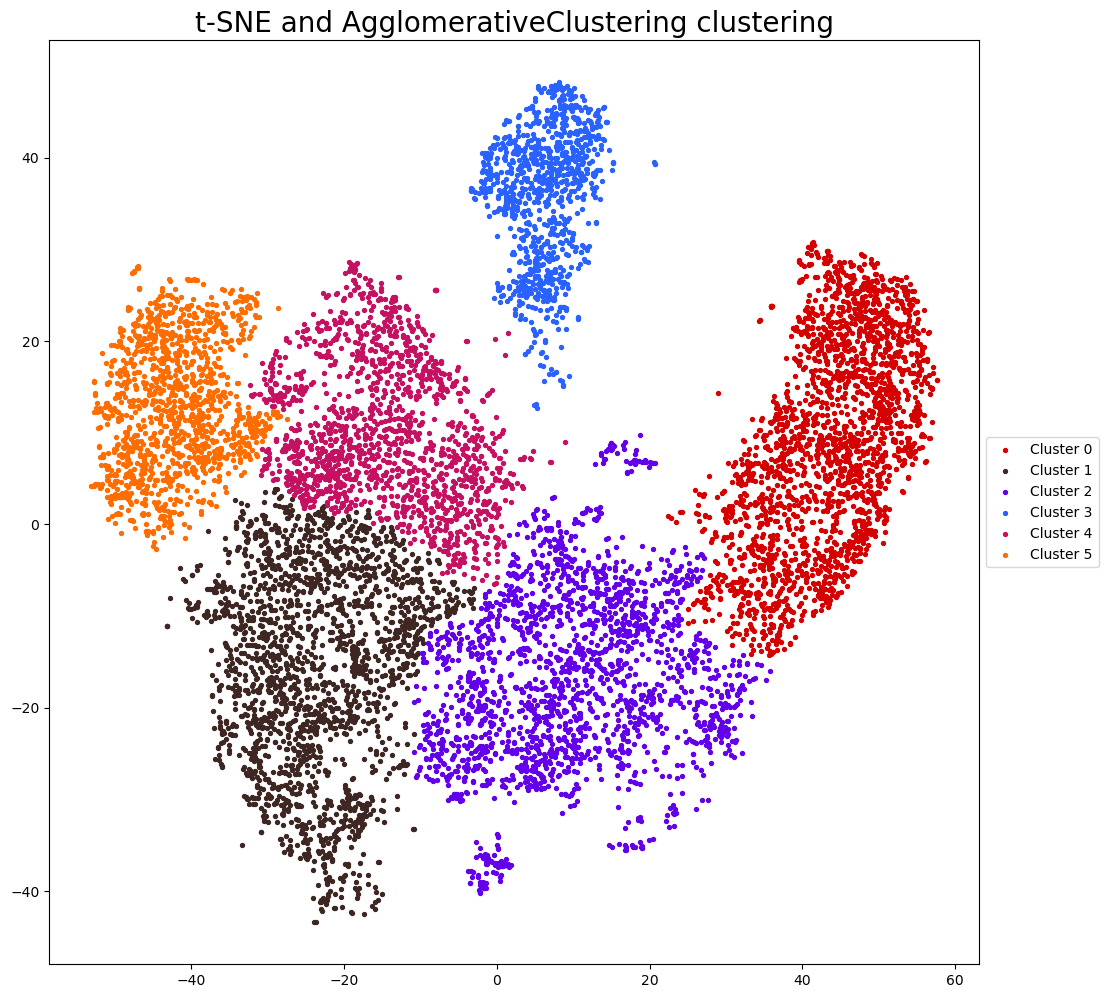

In [39]:
clustering_pipeline(feat_df=all_df, y_param=Location_y_param, colors=all_colors, s=8, algorithm='AgglomerativeClustering', manual_n_clusters=None, subset_values=['Lymph Nodes', 'Lung mets', 'Liver mets', 'Bone mets', 'Adrenal mets', 'Abdopelvis mets', 'Brain mets'])                    

## All lesions except Lymph nodes

100%|██████████| 200/200 [02:48<00:00,  1.18trial/s, best loss: -0.5365893448959569]
Best KMeans parameters: {'n_clusters': 3}
Variation of Information: 1.1772455450904604
Adjusted Rand Index: 0.5365893448959569
Wasserstein Distance: 2.9840914740243596
Silhoutte Score: 0.4873972237110138

Contingency Table (Ground Truth vs Cluster):
Cluster             0     1    2
Ground Truth                    
Abdopelvis mets    32   719  222
Adrenal mets        2   138    1
Bone mets          33    41  957
Brain mets          1    36    0
Liver mets         57  2327   17
Lung mets        2464    56   14
Primary           530   385   14

Percentage of each Ground Truth in each Cluster:
Cluster                  0          1          2
Ground Truth                                    
Abdopelvis mets   3.288798  73.895170  22.816033
Adrenal mets      1.418440  97.872340   0.709220
Bone mets         3.200776   3.976722  92.822502
Brain mets        2.702703  97.297297   0.000000
Liver mets        2.3740

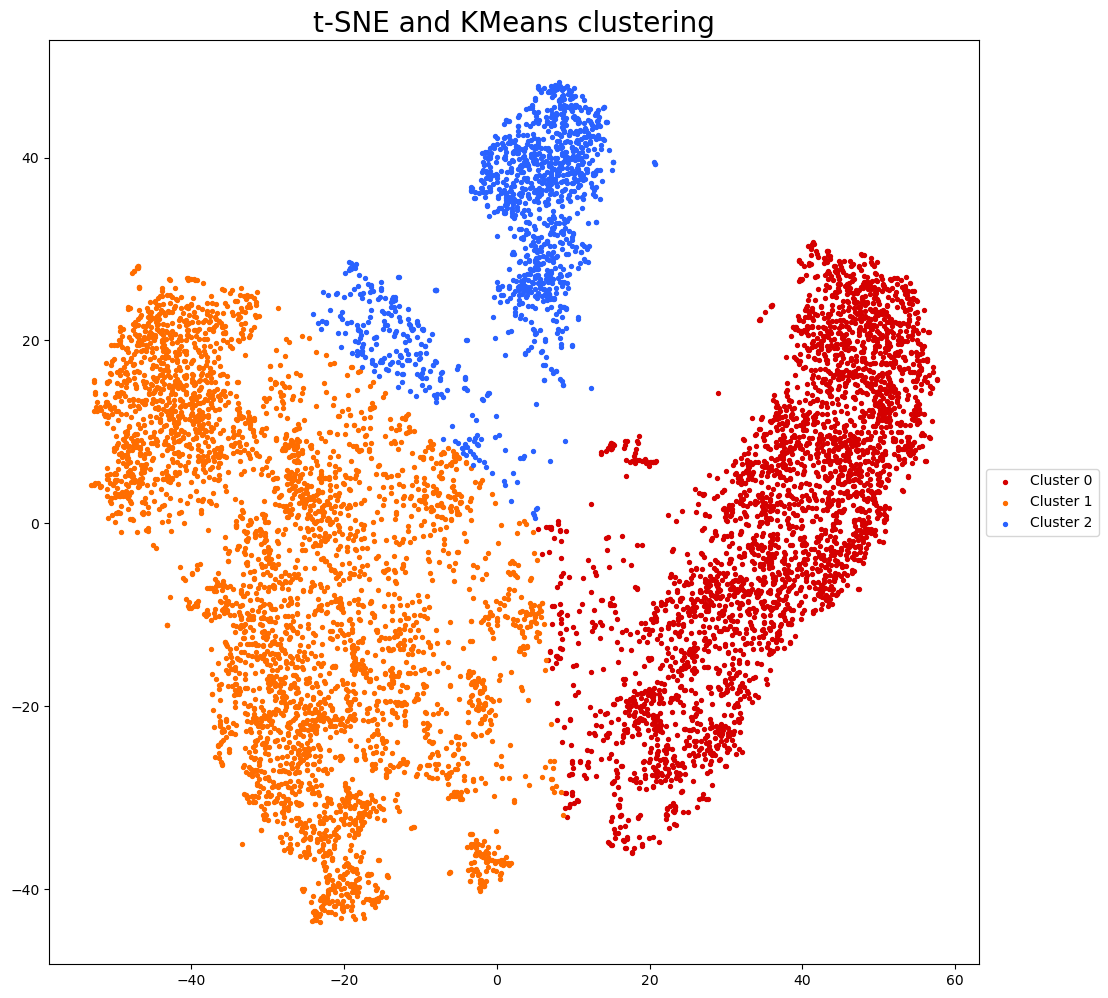

In [46]:
clustering_pipeline(feat_df=all_df, y_param=Location_y_param, colors=all_colors, s=8, algorithm='KMeans', manual_n_clusters=None, subset_values=['Primary', 'Lung mets', 'Liver mets', 'Bone mets', 'Adrenal mets', 'Abdopelvis mets', 'Brain mets'])                    

100%|██████████| 200/200 [07:25<00:00,  2.23s/trial, best loss: -0.4942152901642268]
Best AgglomerativeClustering parameters: {'n_clusters': 3, 'affinity': 'l1', 'linkage': 'average'}
Variation of Information: 1.1581124193909498
Adjusted Rand Index: 0.5054385570988545
Wasserstein Distance: 3.10365398956003
Silhoutte Score: 0.482992023229599

Contingency Table (Ground Truth vs Cluster):
Cluster             0     1    2
Ground Truth                    
Abdopelvis mets   903    60   10
Adrenal mets      139     2    0
Bone mets          53    39  939
Brain mets         36     1    0
Liver mets       2263   135    3
Lung mets          53  2476    5
Primary           378   539   12

Percentage of each Ground Truth in each Cluster:
Cluster                  0          1          2
Ground Truth                                    
Abdopelvis mets  92.805755   6.166495   1.027749
Adrenal mets     98.581560   1.418440   0.000000
Bone mets         5.140640   3.782735  91.076625
Brain mets       97

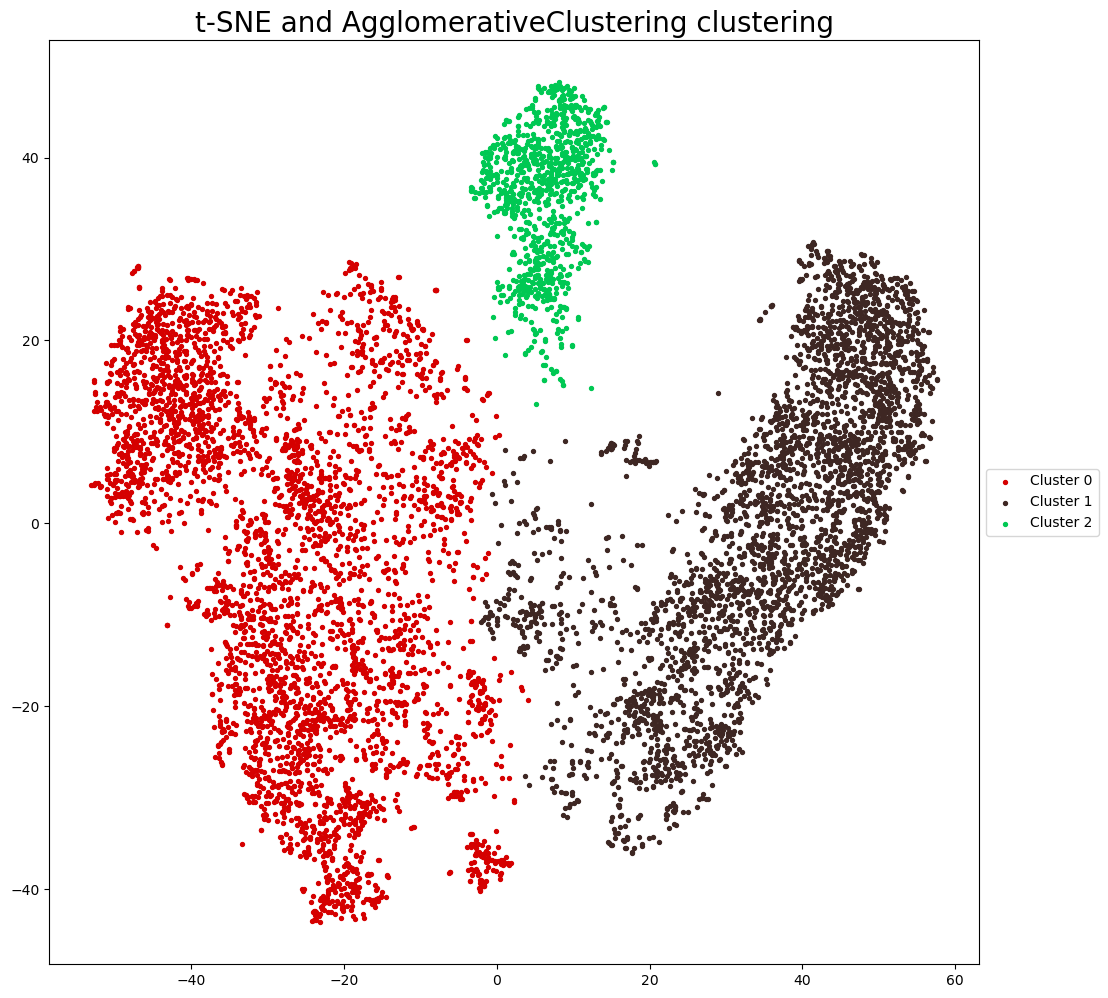

In [75]:
clustering_pipeline(feat_df=all_df, y_param=Location_y_param, colors=all_colors, s=8, algorithm='AgglomerativeClustering',manual_n_clusters=None, subset_values=['Primary', 'Lung mets', 'Liver mets', 'Bone mets', 'Adrenal mets', 'Abdopelvis mets', 'Brain mets'])                    

## All lesions except primary and Lymph nodes

100%|██████████| 200/200 [03:03<00:00,  1.09trial/s, best loss: -0.672735999646045]
Best KMeans parameters: {'n_clusters': 3}
Variation of Information: 0.8362377244607895
Adjusted Rand Index: 0.672735999646045
Wasserstein Distance: 2.7587466629197697
Silhoutte Score: 0.5128303170204163

Contingency Table (Ground Truth vs Cluster):
Cluster             0     1    2
Ground Truth                    
Abdopelvis mets   743    25  205
Adrenal mets      138     2    1
Bone mets          43    31  957
Brain mets         36     1    0
Liver mets       2334    49   18
Lung mets          62  2460   12

Percentage of each Ground Truth in each Cluster:
Cluster                  0          1          2
Ground Truth                                    
Abdopelvis mets  76.361768   2.569373  21.068859
Adrenal mets     97.872340   1.418440   0.709220
Bone mets         4.170708   3.006790  92.822502
Brain mets       97.297297   2.702703   0.000000
Liver mets       97.209496   2.040816   0.749688
Lung mets 

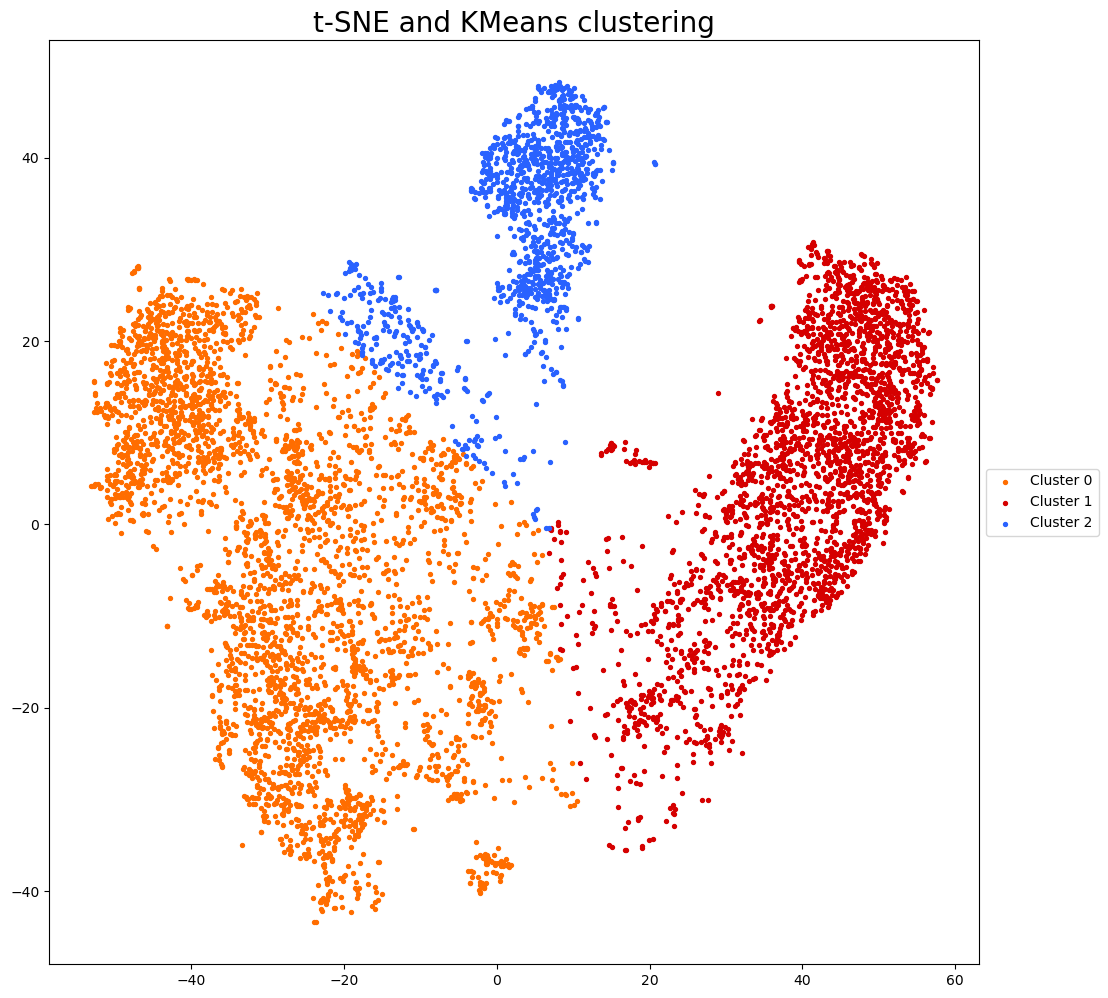

In [56]:
clustering_pipeline(feat_df=all_df, y_param=Location_y_param, colors=all_colors, s=8, algorithm='KMeans',manual_n_clusters=None, subset_values=[ 'Lung mets', 'Liver mets', 'Bone mets', 'Adrenal mets', 'Abdopelvis mets', 'Brain mets'])                    

100%|██████████| 200/200 [05:17<00:00,  1.59s/trial, best loss: -0.5855298420041835]
Best AgglomerativeClustering parameters: {'n_clusters': 3, 'affinity': 'euclidean', 'linkage': 'ward'}
Variation of Information: 0.7399221776377476
Adjusted Rand Index: 0.6590263406932424
Wasserstein Distance: 2.825488267528453
Silhoutte Score: 0.5120333433151245

Contingency Table (Ground Truth vs Cluster):
Cluster             0     1    2
Ground Truth                    
Abdopelvis mets   930    18   25
Adrenal mets      139     2    0
Bone mets          56    34  941
Brain mets         36     1    0
Liver mets       2367    30    4
Lung mets          85  2444    5

Percentage of each Ground Truth in each Cluster:
Cluster                  0          1          2
Ground Truth                                    
Abdopelvis mets  95.580678   1.849949   2.569373
Adrenal mets     98.581560   1.418440   0.000000
Bone mets         5.431620   3.297769  91.270611
Brain mets       97.297297   2.702703   0.0000

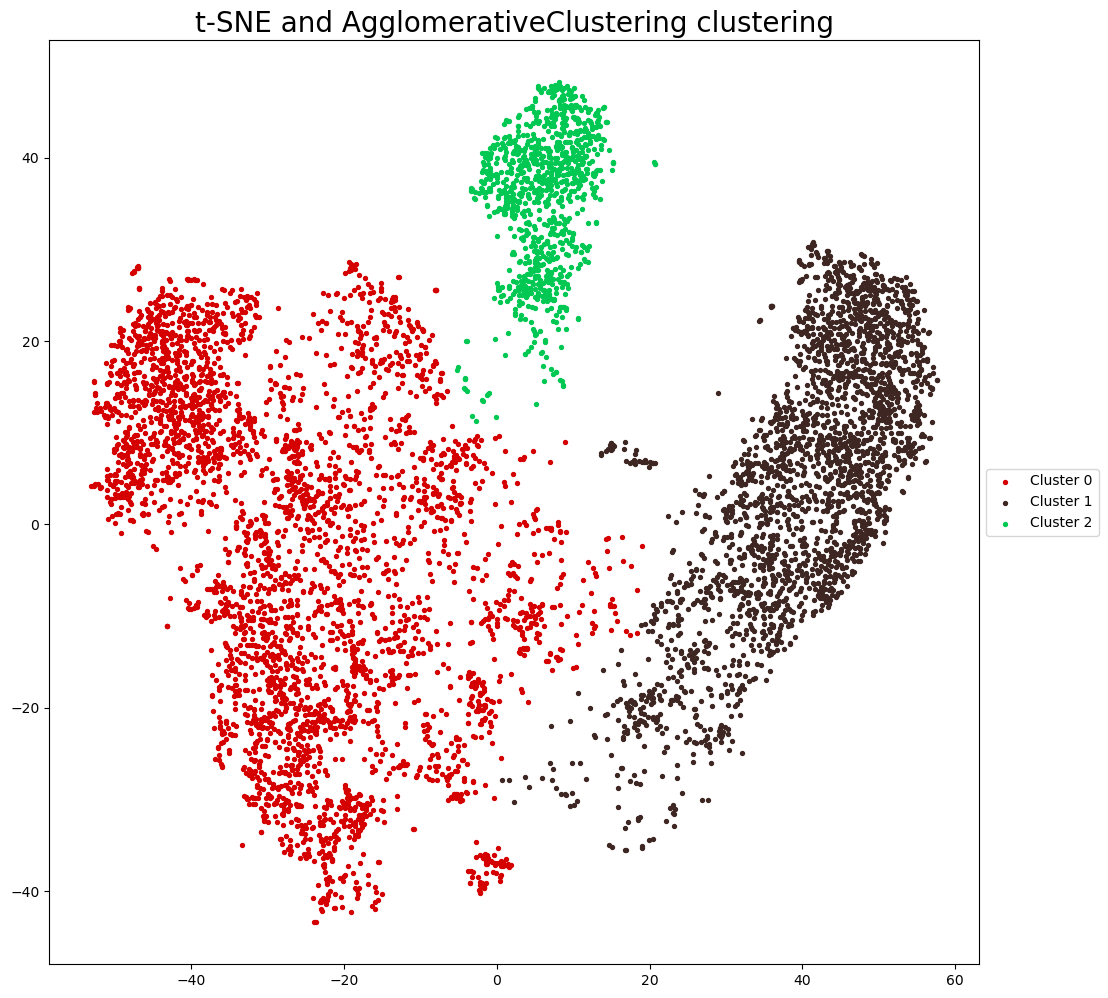

In [73]:
clustering_pipeline(feat_df=all_df, y_param=Location_y_param, colors=all_colors, s=8, algorithm='AgglomerativeClustering', manual_n_clusters=None, subset_values=[ 'Lung mets', 'Liver mets', 'Bone mets', 'Adrenal mets', 'Abdopelvis mets', 'Brain mets'])                    

## Only Primary tumors

100%|██████████| 200/200 [02:56<00:00,  1.14trial/s, best loss: -0.4566365606477387]
Best KMeans parameters: {'n_clusters': 2}
Variation of Information: 0.932643248275471
Adjusted Rand Index: 0.41511183517983113
Wasserstein Distance: 0.0226049515608181
Silhoutte Score: 0.49816128611564636

Contingency Table (Ground Truth vs Cluster):
Cluster         0    1
Ground Truth          
0             404   93
1              72  360

Percentage of each Ground Truth in each Cluster:
Cluster               0          1
Ground Truth                      
0             81.287726  18.712274
1             16.666667  83.333333

Percentage of each Cluster in each Ground Truth:
Cluster              0          1
Ground Truth                     
0             84.87395  20.529801
1             15.12605  79.470199


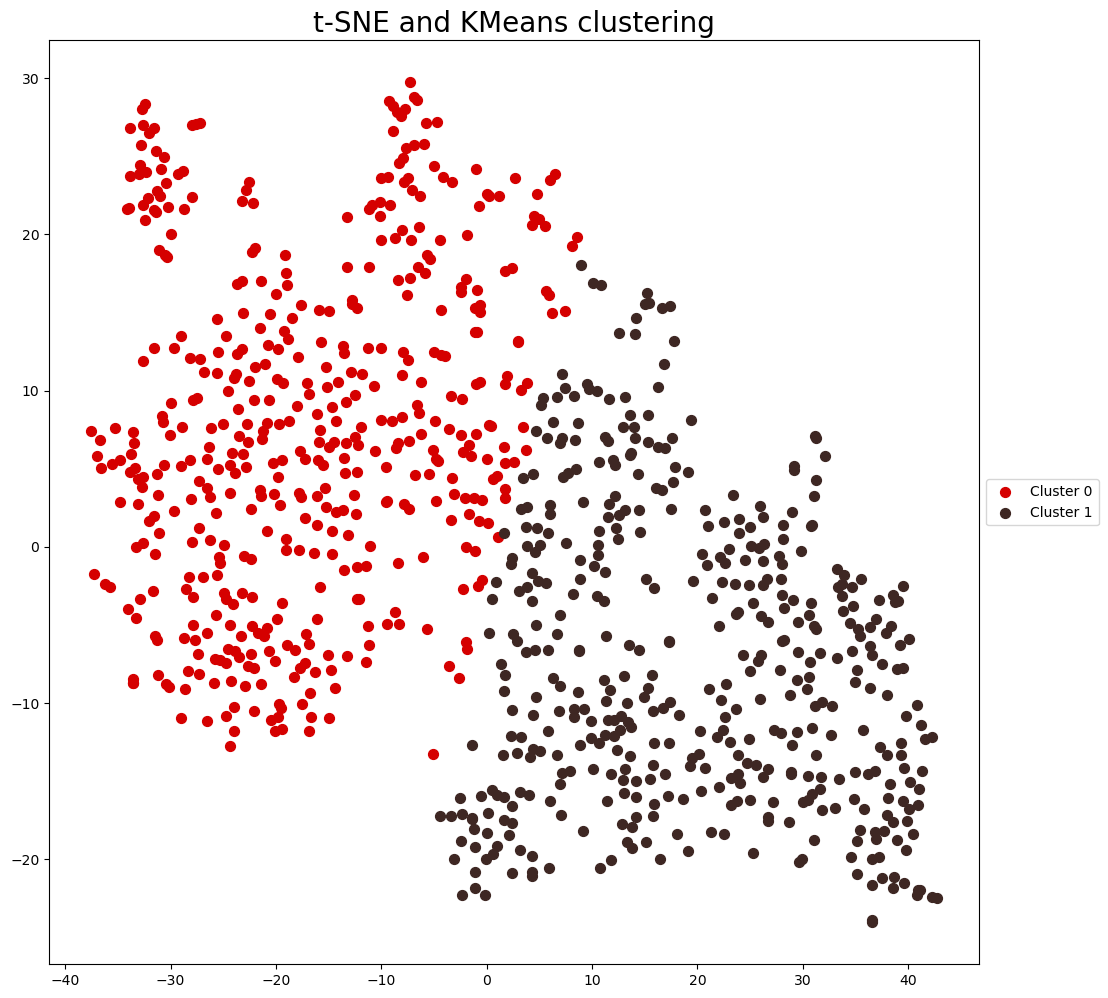

In [77]:
clustering_pipeline(feat_df=primary_feat_df, y_param=primary_lung_y_param, colors=all_colors, s=50, algorithm='KMeans', manual_n_clusters=None, subset_values=None)                           

100%|██████████| 200/200 [00:03<00:00, 54.19trial/s, best loss: -0.4151008581284905]
Best AgglomerativeClustering parameters: {'n_clusters': 2, 'affinity': 'l2', 'linkage': 'average'}
Variation of Information: 0.9105575236778478
Adjusted Rand Index: 0.4151008581284905
Wasserstein Distance: 0.0021528525296017342
Silhoutte Score: 0.48165982961654663

Contingency Table (Ground Truth vs Cluster):
Cluster         0    1
Ground Truth          
0             116  381
1             383   49

Percentage of each Ground Truth in each Cluster:
Cluster               0          1
Ground Truth                      
0             23.340040  76.659960
1             88.657407  11.342593

Percentage of each Cluster in each Ground Truth:
Cluster               0          1
Ground Truth                      
0             23.246493  88.604651
1             76.753507  11.395349


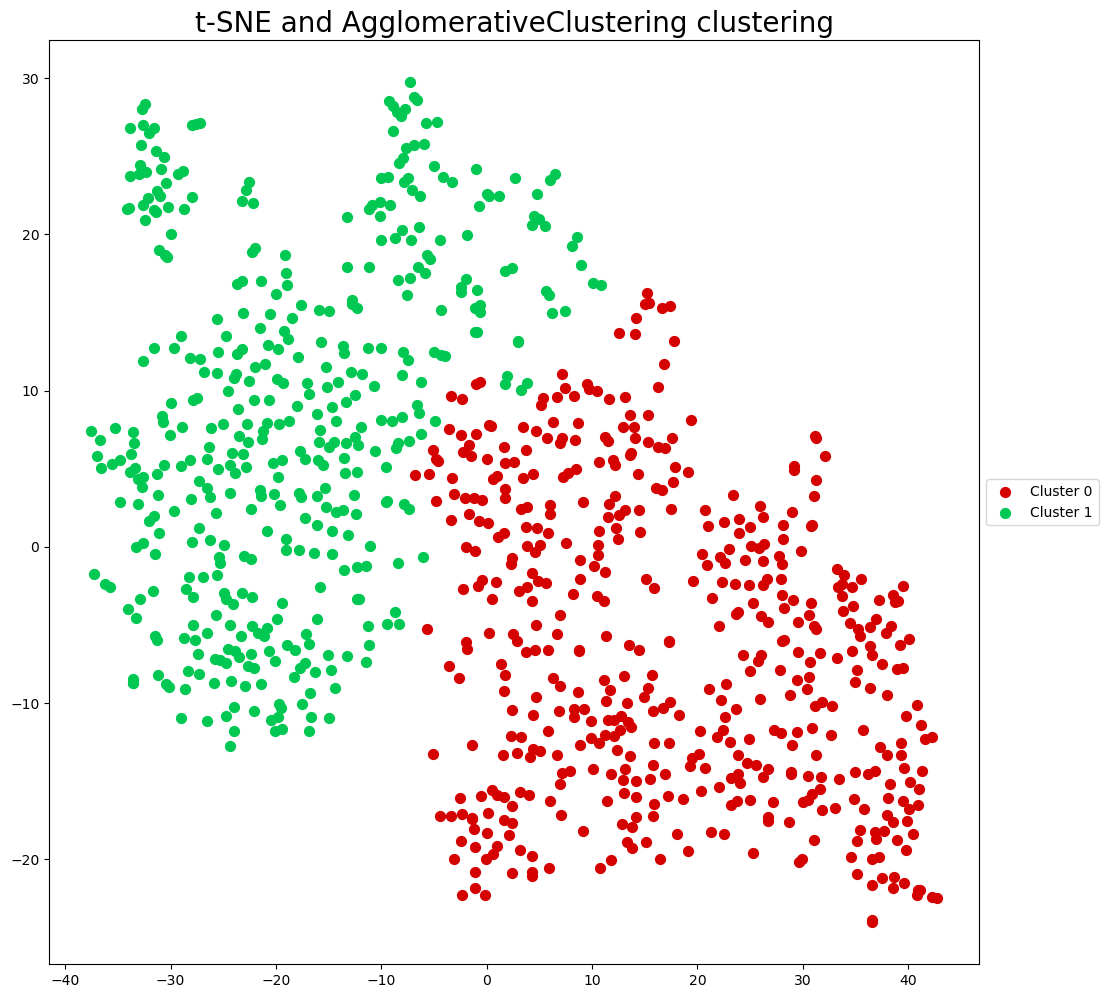

In [65]:
clustering_pipeline(feat_df=primary_feat_df, y_param=primary_lung_y_param, colors=all_colors, s=50, algorithm='AgglomerativeClustering', manual_n_clusters=None, subset_values=None)                           